In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.18.0


## Reading the data

In [ ]:
import pandas as pd

### Currently data scraped on 6rd of Jan

In [4]:
file_path = 'weekly_dataset/top_reddit_posts_week.csv'

In [5]:
df = pd.read_csv(file_path)

print(df.head())
print(df.info())

   Unnamed: 0                                              Title  \
0           0  For those who think the billionaire Soros is s...   
1           1  What is the weirdest fetish one of your exes h...   
2           2  Ladies, what is your butt vs boobs equivalent ...   
3           3  If you have ever felt disgusted by a partner y...   
4           4  Left handed people - what in the world just do...   

                 Author  Subreddit  Score  \
0          funkymunkPDX  AskReddit  19037   
1             astroray_  AskReddit   9705   
2             Epicarest  AskReddit   9385   
3  Negative_Anything_77  AskReddit   9067   
4   father-fluffybottom  AskReddit   8793   

                                           Permalink  Creation Time  \
0  /r/AskReddit/comments/1htdpiu/for_those_who_th...   1.735995e+09   
1  /r/AskReddit/comments/1hrm1ou/what_is_the_weir...   1.735794e+09   
2  /r/AskReddit/comments/1htlovo/ladies_what_is_y...   1.736018e+09   
3  /r/AskReddit/comments/1hqf70t/if_

In [6]:
print("Missing values:\n", df.isnull().sum())
print("Dataset shape:", df.shape)
print("Sample titles:\n", df['Title'].head())

Missing values:
 Unnamed: 0               0
Title                    0
Author                   0
Subreddit                0
Score                    0
Permalink                0
Creation Time            0
Number of Comments       0
Upvote Ratio             0
URL                      0
Post ID                  0
Is Original Content      0
Flair                  107
Comments                 0
dtype: int64
Dataset shape: (250, 14)
Sample titles:
 0    For those who think the billionaire Soros is s...
1    What is the weirdest fetish one of your exes h...
2    Ladies, what is your butt vs boobs equivalent ...
3    If you have ever felt disgusted by a partner y...
4    Left handed people - what in the world just do...
Name: Title, dtype: object


## Filtering the important columns

In [7]:
df = df[['Title', 'Score', 'Comments', 'Subreddit']]
print(df.head())

                                               Title  Score  \
0  For those who think the billionaire Soros is s...  19037   
1  What is the weirdest fetish one of your exes h...   9705   
2  Ladies, what is your butt vs boobs equivalent ...   9385   
3  If you have ever felt disgusted by a partner y...   9067   
4  Left handed people - what in the world just do...   8793   

                                            Comments  Subreddit  
0  [{'Comment ID': 'm5codca', 'Comment Author': '...  AskReddit  
1  [{'Comment ID': 'm4zcm74', 'Comment Author': '...  AskReddit  
2  [{'Comment ID': 'm5ecdav', 'Comment Author': '...  AskReddit  
3  [{'Comment ID': 'm4qo62a', 'Comment Author': '...  AskReddit  
4  [{'Comment ID': 'm4iizhc', 'Comment Author': '...  AskReddit  


## Filtering the 'worldnews' subreddit posts

In [8]:
df_worldnews = df[df['Subreddit'] == 'worldnews']

print(df_worldnews.head())
print("Filtered dataset size:", df_worldnews.shape)

                                                Title  Score  \
50  Server found in apartment funded by Russian go...  56881   
51  BBC News - US Treasury says it was hacked by C...  29870   
52  Berlin accuses Elon Musk of seeking to influen...  29548   
53  Forbes: Elon Musk Pushes For Britain’s King Ch...  29453   
54  ‘Shoot All the Locals’ – Russian Officer Order...  28186   

                                             Comments  Subreddit  
50  [{'Comment ID': 'm4t7iwx', 'Comment Author': '...  worldnews  
51  [{'Comment ID': 'm4lhh3f', 'Comment Author': '...  worldnews  
52  [{'Comment ID': 'm4is5dn', 'Comment Author': '...  worldnews  
53  [{'Comment ID': 'm5hk91k', 'Comment Author': '...  worldnews  
54  [{'Comment ID': 'm4vak1m', 'Comment Author': '...  worldnews  
Filtered dataset size: (50, 4)


### We will utilize the siebert/sentiment-roberta-large-english LLM from huggingface.co for sentiment analysis of comments across the posts.

In [11]:
from transformers import pipeline

In [12]:
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english", 
                              tokenizer="siebert/sentiment-roberta-large-english", truncation=True)

I0000 00:00:1736163487.277197    1160 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at siebert/sentiment-roberta-large-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


In [13]:
import re

In [14]:
# Function to cleaning up the comments
def preprocess_comment(comment):
    # Remove URLs
    comment = re.sub(r'http\S+|www.\S+', '', comment)
    # Remove markdown formatting (e.g., ">quote")
    comment = re.sub(r'>', '', comment)
    # Remove leftover "Excerpt from [" with or without closing brackets
    comment = re.sub(r'Excerpt from \[.*$', '', comment)
    # Remove excessive whitespace
    comment = re.sub(r'\s+', ' ', comment).strip()
    return comment

### Sentiment analysis across the posts from 'worldnews' subreddit

In [16]:
import ast

In [17]:
def analyze_comments(row):
    comments_list = ast.literal_eval(row['Comments'])
    comment_texts = [preprocess_comment(comment['Comment Content']) for comment in comments_list]
    results = sentiment_analysis(comment_texts)
    for comment, sentiment in zip(comments_list, results):
        comment['Sentiment'] = sentiment['label']
    return str(comments_list)

In [18]:
df_worldnews = df_worldnews.copy()  # Avoid SettingWithCopyWarning
df_worldnews['Comments'] = df_worldnews.apply(analyze_comments, axis=1)

### Save the file for future analyses

In [23]:
output_file = "df_worldnews_with_sentiment.csv"
df_worldnews.to_csv(output_file, index=False)

### Sentiment distribution

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_1160/2964240261.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sentiment_counts_flat, palette='coolwarm')


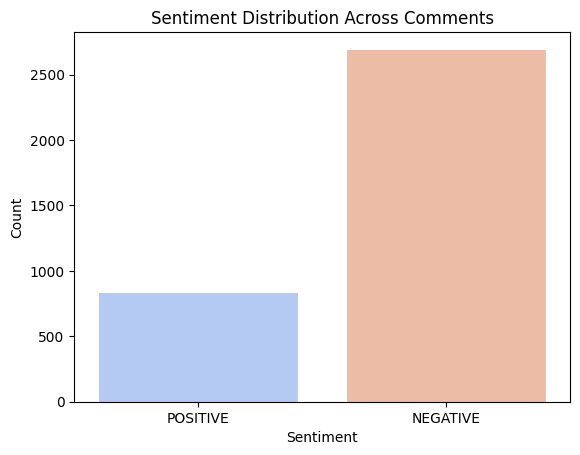

In [27]:
# Count the occurrences of each sentiment
sentiment_counts = df_worldnews['Comments'].apply(lambda x: [comment['Sentiment'] for comment in eval(x)])
sentiment_counts_flat = [sent for sublist in sentiment_counts for sent in sublist]

# Plot sentiment distribution
sns.countplot(x=sentiment_counts_flat, palette='coolwarm')
plt.title("Sentiment Distribution Across Comments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Sentiment by post

In [28]:
def calculate_sentiment_ratio(comments):
    comments = eval(comments)
    sentiments = [comment['Sentiment'] for comment in comments]
    positive_count = sentiments.count('POSITIVE')
    total_count = len(sentiments)
    return positive_count / total_count if total_count > 0 else 0

In [29]:
# Apply to calculate sentiment ratio for each post
df_worldnews['Positive Sentiment Ratio'] = df_worldnews['Comments'].apply(calculate_sentiment_ratio)

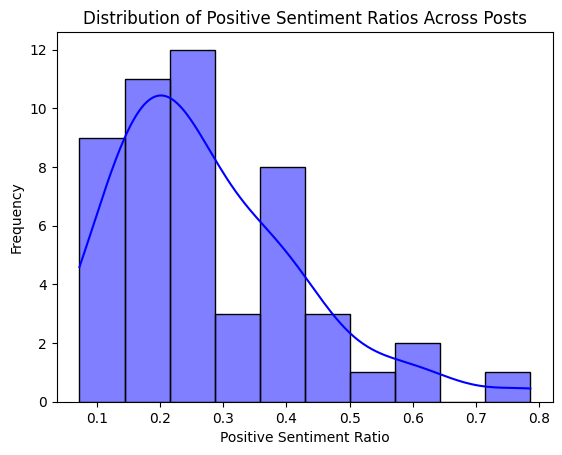

In [30]:
# Visualize
sns.histplot(df_worldnews['Positive Sentiment Ratio'], kde=True, bins=10, color='blue')
plt.title("Distribution of Positive Sentiment Ratios Across Posts")
plt.xlabel("Positive Sentiment Ratio")
plt.ylabel("Frequency")
plt.show()

### Top 3 Positive and Negative Posts

In [34]:
# Sort posts by positive sentiment ratio
top_positive_posts = df_worldnews.sort_values(by='Positive Sentiment Ratio', ascending=False).head(3)
top_negative_posts = df_worldnews.sort_values(by='Positive Sentiment Ratio', ascending=True).head(3)

In [32]:
# To allow full display of the titles
pd.set_option('display.max_colwidth', None)

In [35]:
print("Top Positive Posts:")
print(top_positive_posts[['Title', 'Positive Sentiment Ratio']])

print("\nTop Negative Posts:")
print(top_negative_posts[['Title', 'Positive Sentiment Ratio']])

Top Positive Posts:
                                                                                                Title  \
94                                 New Syrian gov't taps Druze woman as governor of southern province   
81  500 tonnes of Ukrainian grain to arrive in Syria on 31 December as part of humanitarian programme   
84             UAE mandates genetic testing for Emirati couples before marriage starting January 2025   

    Positive Sentiment Ratio  
94                  0.785714  
81                  0.625000  
84                  0.589744  

Top Negative Posts:
                                                                                                                     Title  \
92                                              Hamas refusing to release some hostages in Gaza deal negotiations - report   
64                                                         UK Right Warns Trump Allies That Musk’s Posts Have Gone Too Far   
53  Forbes: Elon Musk Pushes For Bri